In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv("~/Desktop/combinedf.csv",parse_dates=['Date'])
data=data[['Date','Traffic','Year','Month','Day','Hour']]

In [3]:
data.head()

,Date,Traffic,Year,Month,Day,Hour
0,2015-01-01 10:15:00,1,2015,1,1,10
1,2015-01-01 10:30:00,4,2015,1,1,10
2,2015-01-01 10:45:00,3,2015,1,1,10
3,2015-01-01 11:00:00,1,2015,1,1,11
4,2015-01-01 11:15:00,2,2015,1,1,11


In [4]:
time_stamp=[]
from datetime import datetime
for year,month,day,hour in zip(data['Year'],data['Month'],data['Day'],data['Hour']):
    concat_date=datetime(year,month,day,hour)
    time_stamp.append(concat_date)

In [5]:
data['time_stamp']=pd.DataFrame(time_stamp)


In [6]:
data_hour=(data.groupby(data['time_stamp']).sum()).reset_index()
data_hour.head()

,time_stamp,Traffic,Year,Month,Day,Hour
0,2015-01-01 10:00:00,8,6045,3,3,30
1,2015-01-01 11:00:00,14,8060,4,4,44
2,2015-01-01 12:00:00,28,8060,4,4,48
3,2015-01-01 13:00:00,33,8060,4,4,52
4,2015-01-01 14:00:00,47,8060,4,4,56


In [7]:
data_hour=data_hour.drop(['Year','Month','Day','Hour'],axis=1)

In [8]:
data_hour.head()

,time_stamp,Traffic
0,2015-01-01 10:00:00,8
1,2015-01-01 11:00:00,14
2,2015-01-01 12:00:00,28
3,2015-01-01 13:00:00,33
4,2015-01-01 14:00:00,47


In [9]:
data_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13957 entries, 0 to 13956
Data columns (total 2 columns):
time_stamp    13957 non-null datetime64[ns]
Traffic       13957 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 218.2 KB


In [10]:
data_hour.set_index(['time_stamp'],inplace=True)

In [11]:
data_hour.head()

,Traffic
time_stamp,
2015-01-01 10:00:00,8
2015-01-01 11:00:00,14
2015-01-01 12:00:00,28
2015-01-01 13:00:00,33
2015-01-01 14:00:00,47


In [12]:
def rolling_mean_std(data,windowsize):
    """
        data - sales data
        windowsize - rolling window size by hours
        
    """
    rolling_mean = data.rolling(window=windowsize).mean()
    rolling_std = data.rolling(window=windowsize).std()

    plt.figure(figsize=(15,5))
    plt.title("{} - Rolling Mean and Std for {} hours window".format(data.name,windowsize),fontsize=16)
    
    plt.plot(rolling_mean, color='red')
    plt.plot(rolling_std,color='green')
    plt.plot(data,color='blue')
    
   
    plt.grid(True)
    plt.legend(('Roliing Mean','Rolling Std','Actual Data'),fontsize=12,loc="upper left")
    plt.xticks(rotation='vertical',fontsize=12)


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


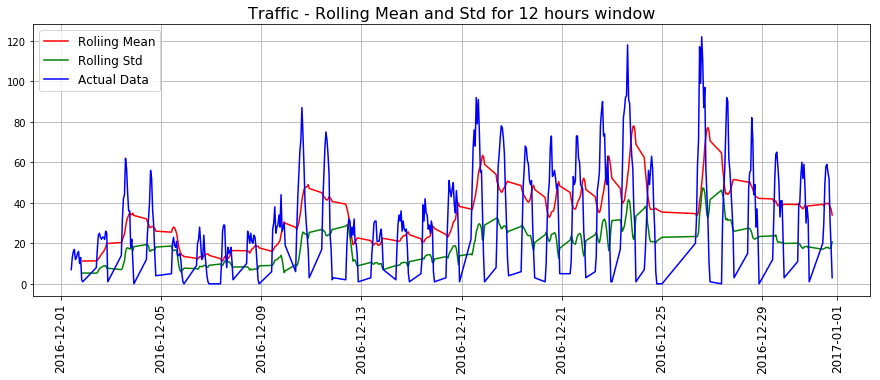

In [13]:
rolling_mean_std(data_hour['Traffic'][(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)], 12) 

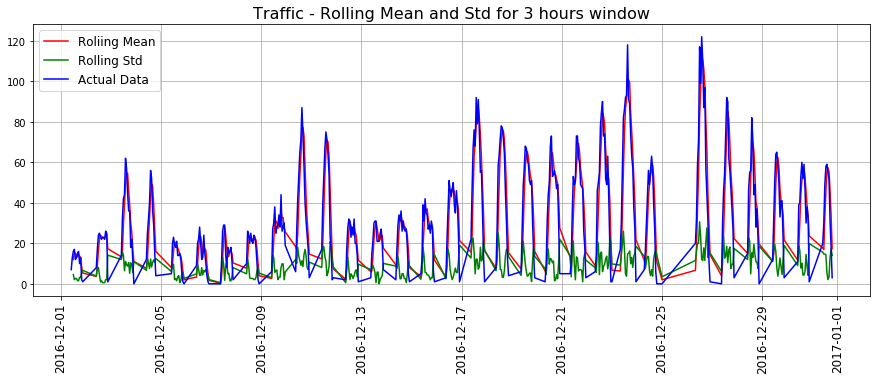

In [14]:
rolling_mean_std(data_hour['Traffic'][(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)],3)

#Inference: we can see the rollling mean is smoother than it was for window size of 12

In [15]:
from sklearn.metrics import mean_absolute_error
def detect_peaks(data,windowsize):
    scale=1
    rolling_mean = data.rolling(window=windowsize).mean()
    rolling_std = data.rolling(window=windowsize).std()
    mae = mean_absolute_error(data[windowsize:], rolling_mean[windowsize:])
    deviation = np.std(data[windowsize:] - rolling_mean[windowsize:])
    lower_bound = rolling_mean - (mae + scale * deviation)
    upper_bound = rolling_mean + (mae + scale * deviation)
    
    peaks=pd.DataFrame(index=data.index,columns=data.columns)
    peaks[data<lower_bound]=data[data<lower_bound]
    peaks[data>upper_bound]=data[data>upper_bound]
    plt.plot(upper_bound, "g--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bound, "g--")
    plt.plot(peaks, "ro", markersize=5)

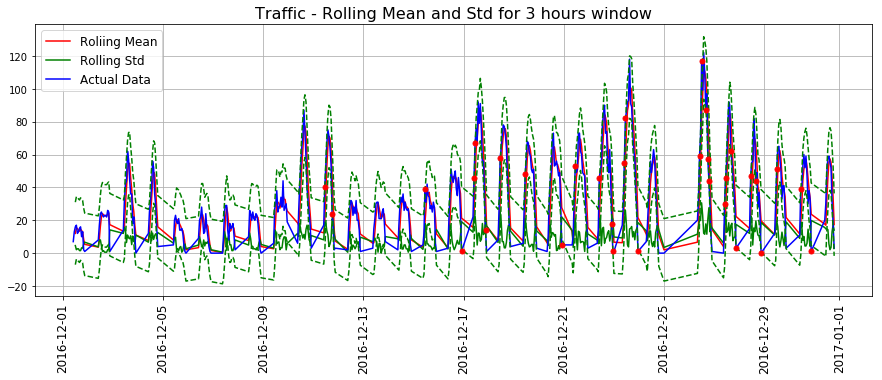

In [16]:
rolling_mean_std(data_hour['Traffic'][(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)],3) 
detect_peaks(data_hour[(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)],3)

In [17]:
#The peaks and lows are captured by the lower and upper bound.

# Is the data Stationary?

In [18]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
adftest = adfuller(data_hour['Traffic'], autolag='AIC')
adfoutput = pd.Series(adftest[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
print (adfoutput)

#inference: P-valus is very much lower 0.05 indicating the it is highly significant. we can reject null hypothesis that the data has a unit root.
# data is stationary.

Results of Dickey-Fuller Test:
ADF Statistic                 -1.271152e+01
p-value                        1.027698e-23
#Lags Used                     4.200000e+01
Number of Observations Used    1.391400e+04
Critical Value (1%)           -3.430820e+00
Critical Value (5%)           -2.861748e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [19]:
#to confirm no differencing is required ndiffs() can be used
from pmdarima.arima.utils import ndiffs
print("ADF Test: ",ndiffs(data_hour['Traffic'], test='adf'))  # 2


ADF Test:  0


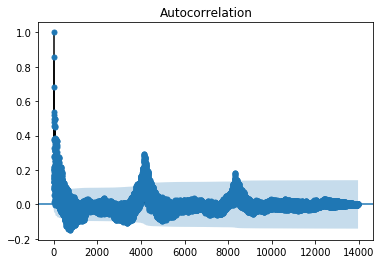

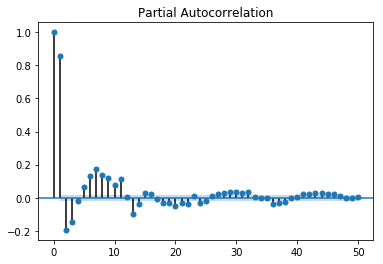

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data_hour['Traffic'])
plt.show()
plot_pacf(data_hour['Traffic'], lags=50)
plt.show()

# Arima model

In [20]:
from statsmodels.tsa.stattools import acf

train = data_hour['Traffic'][np.logical_not((pd.DatetimeIndex(data_hour.index).year==2017)&(pd.DatetimeIndex(data_hour.index).month==12))]
test = data_hour['Traffic'][(pd.DatetimeIndex(data_hour.index).year==2017)&(pd.DatetimeIndex(data_hour.index).month==12)]

In [21]:
test.shape

(391,)

In [22]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=8, max_q=8, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Forecast
n_periods = 391
plt.figure(figsize=(15,5))
pred = model.predict(n_periods=n_periods)


print(model.summary())

#Inference: we can see the p-value is considerbaly low.

Fit ARIMA: order=(0, 0, 0); AIC=110973.704, BIC=110988.734, Fit time=0.006 seconds
Fit ARIMA: order=(1, 0, 0); AIC=93729.710, BIC=93752.256, Fit time=0.151 seconds
Fit ARIMA: order=(0, 0, 1); AIC=100945.858, BIC=100968.404, Fit time=0.142 seconds
Fit ARIMA: order=(2, 0, 0); AIC=93250.705, BIC=93280.767, Fit time=0.144 seconds
Fit ARIMA: order=(2, 0, 1); AIC=93073.886, BIC=93111.463, Fit time=1.925 seconds
Fit ARIMA: order=(3, 0, 2); AIC=91704.860, BIC=91757.467, Fit time=4.322 seconds
Fit ARIMA: order=(2, 0, 2); AIC=92926.823, BIC=92971.915, Fit time=1.917 seconds
Fit ARIMA: order=(4, 0, 2); AIC=91623.120, BIC=91683.243, Fit time=2.987 seconds
Fit ARIMA: order=(4, 0, 1); AIC=92483.055, BIC=92535.662, Fit time=4.103 seconds
Fit ARIMA: order=(4, 0, 3); AIC=91601.716, BIC=91669.354, Fit time=4.628 seconds
Fit ARIMA: order=(5, 0, 4); AIC=91600.444, BIC=91683.112, Fit time=7.257 seconds
Fit ARIMA: order=(4, 0, 4); AIC=91601.014, BIC=91676.168, Fit time=5.850 seconds
Fit ARIMA: order=(6, 0, 

<Figure size 1080x360 with 0 Axes>

In [23]:
from math import sqrt
sqrt(mean_absolute_error(pred,test))

4.890589693686831

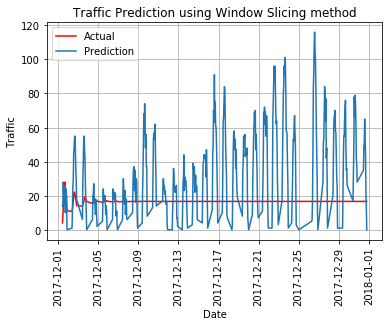

In [24]:
plt.plot(test.index,pred,color='red')
plt.plot(test.index,test)
plt.xticks(rotation='vertical')
plt.title("Traffic Prediction using Window Slicing method")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Traffic")
plt.legend(("Actual","Prediction"))

# Window Slicing Method

In [25]:
#selecting traffic data
data=data.iloc[:,1:2].values

In [26]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
# Creating a data structure with 60 timesteps and 1 output

X_train = []
y_train = []
for i in range(61, 13558):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [28]:
y_train.shape

(13497,)

In [29]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(13497, 60, 1)

In [30]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [31]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))

In [33]:
regressor.add(Dense(units = 1))

In [34]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [35]:
regressor.fit(X_train, y_train, epochs =10 , batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
13497/13497 [==============================] - 90s 7ms/step - loss: 0.0041
Epoch 2/10
13497/13497 [==============================] - 86s 6ms/step - loss: 0.0033
Epoch 3/10
13497/13497 [==============================] - 84s 6ms/step - loss: 0.0032
Epoch 4/10
13497/13497 [==============================] - 91s 7ms/step - loss: 0.0031
Epoch 5/10
13497/13497 [==============================] - 88s 7ms/step - loss: 0.0031
Epoch 6/10
13497/13497 [==============================] - 86s 6ms/step - loss: 0.0030
Epoch 7/10
13497/13497 [==============================] - 81s 6ms/step - loss: 0.0031
Epoch 8/10
13497/13497 [==============================] - 84s 6ms/step - loss: 0.0030
Epoch 9/10
13497/13497 [==============================] - 87s 6ms/step - loss: 0.0030
Epoch 10/10
13497/13497 [==============================] - 85s 6ms/step - loss: 0.0030


In [36]:
data=pd.read_csv("~/Desktop/combinedf.csv",parse_dates=['Date'])
data.head()

,Date,Sales,Traffic,Week_day,Month,Day,Year,date_delta,Leave,Holiday_Season,Traffic_Range,Sales_Range,Minute,Hour,Quarter
0,2015-01-01 10:15:00,662,1,3,1,1,2015,0.000000,0,0,1,1-725,15,10,2
1,2015-01-01 10:30:00,740,4,3,1,1,2015,0.010417,0,0,4,725-750,30,10,2
2,2015-01-01 10:45:00,655,3,3,1,1,2015,0.020833,0,0,3,1-725,45,10,2
3,2015-01-01 11:00:00,751,1,3,1,1,2015,0.031250,0,0,1,750-775,0,11,2
4,2015-01-01 11:15:00,730,2,3,1,1,2015,0.041667,0,0,2,725-750,15,11,2


In [37]:
data=data.iloc[:,2].values
inputs = data.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(13559, 13948):
    
    X_test.append(inputs[i-60:i, 0])
    

X_test = np.array(X_test)
actual=X_test
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_traffic = regressor.predict(X_test)
predicted_traffic = sc.inverse_transform(predicted_traffic)

In [38]:
data=pd.read_csv("~/Desktop/combinedf.csv",parse_dates=['Date'])
actual=data.iloc[13559:13948,2]

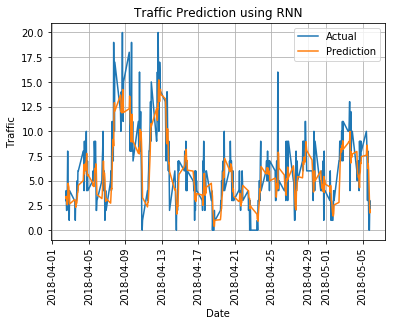

In [39]:
plt.plot(data_hour[13559:13948].index,actual)
plt.plot(data_hour[13559:13948].index,predicted_traffic )
plt.xticks(rotation='vertical')
plt.title("Traffic Prediction using RNN")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Traffic")
plt.legend(("Actual","Prediction"))

In [40]:
sqrt(mean_absolute_error(actual,predicted_traffic))

1.4080514536827502

In [41]:
#Inference: The Traffic prediction is capturing the peaks and 
#lows to a certain extent and also the RMSE error is 1.4 suggesting this model is better than ARIMA method.